# Capstone: Web Traffic Time Series Forecasting

![web](images/map_webtraffic.png)

reference: [Kaggle Challenge 2017](https://www.kaggle.com/competitions/web-traffic-time-series-forecasting/data)

- Web traffic can be defined as the number of visits to a website, including requests sent and received by web users. We aim to predict future web traffic for approximately a total of 145k Wikipedia articles to make better traffic control decisions. The increase in traffic for the websites could cause a lot of inconvenience for the users by a crashed site or very slow loading time. Therefore, a traffic management technique or plan should be put in place to reduce the risk of such problems.

# Import packages and define functions

In [25]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import seaborn as sns
import datetime 
from collections import Counter

%matplotlib inline 

sns.set_style('ticks', rc={'xtick.direction':'in', 'ytick.direction':'in', \
                           'xtick.top':True, 'ytick.right':True})

# Data Collection and Wrangling

In [3]:
datadir = '../datasets/raw'
datadir_pr = '../datasets/processed'  # directory where the cleaned datasets are stored

## Datasets consist of train and key:
- **train.csv**
    - 145k rows each of wich represent a different Wikipedia page
    - 804 columns: article + daily traffic on that particular Wikipedia page (803 days: 2015-07-01 to 2017-09-10)
    - The first column contains the name of the page which includes 
        - the language of the page (e.g., English en, Spanish es, Chinese zh)
        - type of access (e.g., desktop, all access)
        - agent (e.g., spider, actual traffic)
- **key.csv**
    - the mapping between the page names and the shortened Id column used for prediction
    - 2 columns: page name (consistent to the page name in train.csv) and id

In [3]:
''' Read the training dataset '''
train = pd.read_csv(os.path.join(datadir, 'train_2.csv.zip'))
key   = pd.read_csv(os.path.join(datadir, 'key_2.csv.zip'))

In [4]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [5]:
key.head()

,Page,Id
0,007_スペクター_ja.wikipedia.org_all-access_all-agen...,0b293039387a
1,007_スペクター_ja.wikipedia.org_all-access_all-agen...,7114389dd824
2,007_スペクター_ja.wikipedia.org_all-access_all-agen...,057b02ff1f09
3,007_スペクター_ja.wikipedia.org_all-access_all-agen...,bd2aca21caa3
4,007_スペクター_ja.wikipedia.org_all-access_all-agen...,c0effb42cdd5


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 804 entries, Page to 2017-09-10
dtypes: float64(803), object(1)
memory usage: 889.8+ MB


In [7]:
key.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8993906 entries, 0 to 8993905
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Page    object
 1   Id      object
dtypes: object(2)
memory usage: 137.2+ MB


In [8]:
''' check the missing values '''
train.isnull().sum()
#train.isnull().values.any()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2017-09-06     1775
2017-09-07     3467
2017-09-08     1061
2017-09-09     3332
2017-09-10     5578
Length: 804, dtype: int64

## Handling Missing values

- There are two kinds of missing in this time series dataset
    1. the data is actually missing --> interpolation 
    2. the page is not created yet --> fill with zero

In [9]:
# omit the page titles
Page_title = train.Page   # keep the page column to revive it after handling the missing data
train_nopage = train.drop(columns=['Page'])

In [10]:
train_nopage.isnull().sum()

2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
2015-07-05    20659
              ...  
2017-09-06     1775
2017-09-07     3467
2017-09-08     1061
2017-09-09     3332
2017-09-10     5578
Length: 803, dtype: int64

In [11]:
# convert the format of column names from string to datetime
train_nopage.columns = pd.to_datetime(train_nopage.columns)

In [12]:
# First situation: the data is actually missing
# interpolation
train_imputed = train_nopage.interpolate(method='linear', axis=1).copy()

In [13]:
train_imputed.isnull().sum()

2015-07-01    20740
2015-07-02    19767
2015-07-03    19256
2015-07-04    18983
2015-07-05    18818
              ...  
2017-09-06        0
2017-09-07        0
2017-09-08        0
2017-09-09        0
2017-09-10        0
Length: 803, dtype: int64

In [14]:
# Second situation: the page is not created yet
# fill with zero
train_imputed.fillna(0, inplace=True)

In [15]:
train_imputed.isnull().sum()

2015-07-01    0
2015-07-02    0
2015-07-03    0
2015-07-04    0
2015-07-05    0
             ..
2017-09-06    0
2017-09-07    0
2017-09-08    0
2017-09-09    0
2017-09-10    0
Length: 803, dtype: int64

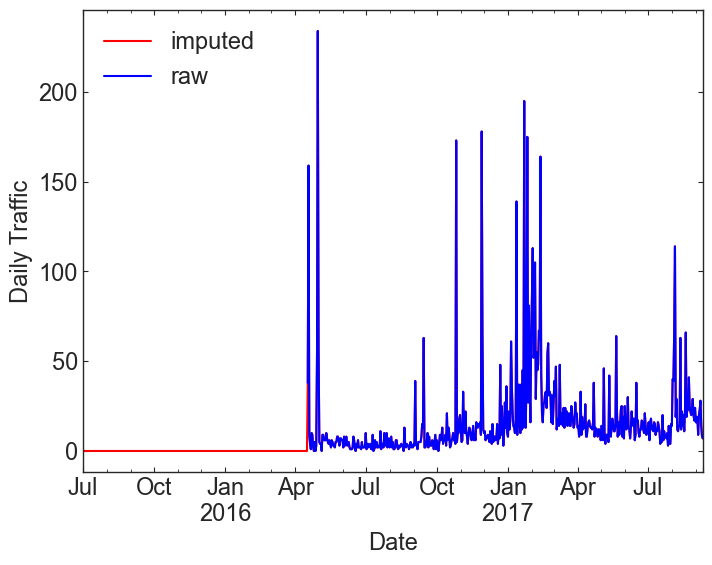

In [16]:
# visualize the imputed dataset
fig, ax = plt.subplots()

n_obs = 4  # location of the page

train_imputed.iloc[n_obs].T.plot(color='red', label='imputed', ax=ax)  # imputed dataset
train_nopage.iloc[n_obs].T.plot(color='blue', label='raw', ax=ax)  # raw dataset

#ax.set_xlim('2015','2017')
ax.set(xlabel='Date', ylabel='Daily Traffic')
ax.legend(loc='upper left', frameon=False);

In [17]:
train_imputed.insert(loc=0, column='Page', value=Page_title)

In [18]:
train_imputed.head()

,Page,2015-07-01 00:00:00,2015-07-02 00:00:00,2015-07-03 00:00:00,2015-07-04 00:00:00,2015-07-05 00:00:00,2015-07-06 00:00:00,2015-07-07 00:00:00,2015-07-08 00:00:00,2015-07-09 00:00:00,...,2017-09-01 00:00:00,2017-09-02 00:00:00,2017-09-03 00:00:00,2017-09-04 00:00:00,2017-09-05 00:00:00,2017-09-06 00:00:00,2017-09-07 00:00:00,2017-09-08 00:00:00,2017-09-09 00:00:00,2017-09-10 00:00:00
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [19]:
print(train_imputed.shape)

(145063, 804)


## save the imputed dataset

In [20]:
train_imputed.to_csv(os.path.join(datadir_pr, 'train_imputed.csv.zip'), index=False, compression='zip')

# Exploratory Data Analysis

In [4]:
''' Read the training dataset '''
train_imputed = pd.read_csv(os.path.join(datadir_pr, 'train_imputed.csv.zip'))

## Grouping by languages

In [19]:
''' function for finding language from given page title '''
def get_language(page):
    lang = re.search('[a-z][a-z].wikipedia', page)
    if lang:
        return lang[0][0:2]
    else:
        return 'NA'

In [20]:
train_imputed['Language'] = train_imputed.Page.map(get_language)

In [24]:
train_imputed[['Page','Language']].sample(10)

,Page,Language
110685,Economy_of_Kazan_en.wikipedia.org_all-access_a...,en
28546,校花的貼身高手_zh.wikipedia.org_all-access_all-agents,zh
130287,Option_fr.wikipedia.org_all-access_spider,fr
97417,Alberto_Núñez_Feijóo_es.wikipedia.org_mobile-w...,es
65762,Heinrich_George_de.wikipedia.org_desktop_all-a...,de
26356,Patrick_Ekeng_Ekeng_fr.wikipedia.org_all-acces...,fr
125760,"Беляев,_Юрий_Викторович_ru.wikipedia.org_all-a...",ru
20142,Microsoft_Word_Macros_www.mediawiki.org_all-ac...,NA
86027,荻野目洋子_ja.wikipedia.org_desktop_all-agents,ja
94056,Breaking_Bad_es.wikipedia.org_mobile-web_all-a...,es


In [34]:
train_imputed.loc[train_imputed.Language=='NA',['Page','Language']]

,Page,Language
13332,Accueil_commons.wikimedia.org_all-access_spider,NA
13333,Atlas_of_Asia_commons.wikimedia.org_all-access...,NA
13334,Atlas_of_Europe_commons.wikimedia.org_all-acce...,NA
13335,Atlas_of_World_War_II_commons.wikimedia.org_al...,NA
13336,Atlas_of_colonialism_commons.wikimedia.org_all...,NA
...,...,...
84730,help:contents_www.mediawiki.org_all-access_spider,NA
84731,how_to_contribute_www.mediawiki.org_all-access...,NA
84732,mediawiki_www.mediawiki.org_all-access_spider,NA
84733,special:book_www.mediawiki.org_all-access_spider,NA


In [26]:
print(Counter(train_imputed.Language))

Counter({'en': 24111, 'ja': 20431, 'de': 18547, 'NA': 17852, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


In [30]:
train_imputed.Language.unique()

array(['zh', 'fr', 'en', 'NA', 'ru', 'de', 'ja', 'es'], dtype=object)

In [37]:
def convert_full_language(lang):
    lang_label = {'zh':'Chinese', 'fr':'French', 'en':'English', \
                  'ru':'Russian', 'de':'German', 'ja':'Japanese', \
                  'es':'Spanish', 'NA':'NA'}
    return lang_label[lang]

train_imputed['Language'] = train_imputed.Language.map(convert_full_language)

### Number of Articles per language

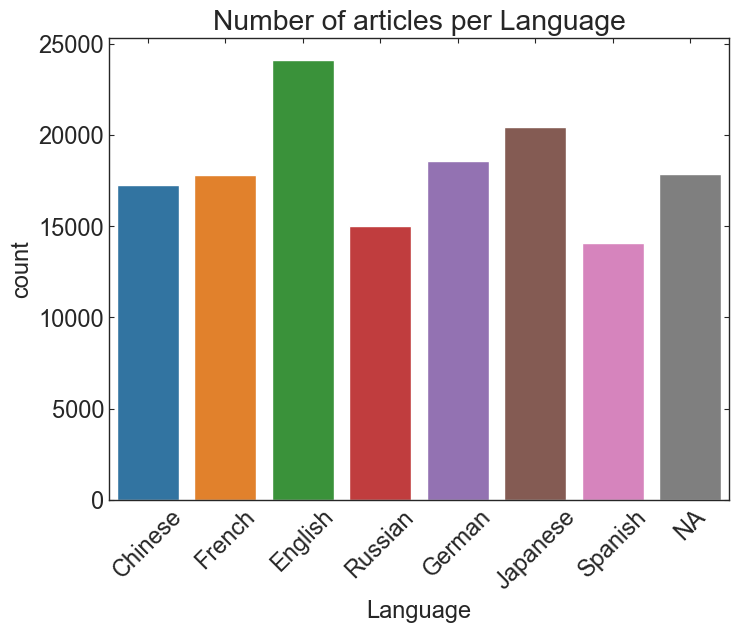

In [43]:
x_order = ['Chinese','French','English','Russian','German','Japanese','Spanish','NA']

ax = sns.countplot(data=train_imputed, x='Language', order=x_order)

ax.tick_params(axis='x', rotation=45)
ax.set_title('Number of articles per Language');

### Daily traffic for articles in the different languages

In [45]:
train_wo_NA = train_imputed.loc[train_imputed.Language != 'NA']

In [51]:
languages = train_wo_NA.Language.unique()
print(languages)

['Chinese' 'French' 'English' 'Russian' 'German' 'Japanese' 'Spanish']


In [75]:
lang_traffic = {}

for lang in languages:
    lang_traffic[lang] = train_imputed.loc[train_imputed.Language == lang].drop(columns=['Page','Language']).sum(axis=0)

In [84]:
df_lang_traffic = pd.DataFrame(lang_traffic)

In [92]:
df_lang_traffic.T

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
Chinese,4144988.0,4.151692e+06,4.123910e+06,4.163694e+06,4.441489e+06,4.464567e+06,4.459718e+06,4.576112e+06,4.548169e+06,4.728224e+06,...,4.769573e+06,5.226684e+06,5.512358e+06,5.075714e+06,5.124686e+06,5.000526e+06,5.212388e+06,5026137.0,5251234.0,5466627.0
French,8458638.0,8.512987e+06,8.186089e+06,8.749959e+06,8.590587e+06,8.949916e+06,8.651196e+06,8.492320e+06,8.403705e+06,7.930772e+06,...,8.905846e+06,8.498777e+06,9.048521e+06,8.177243e+06,7.986859e+06,9.226393e+06,9.071040e+06,8008422.0,8448785.0,9115857.0
English,84712190.0,8.443924e+07,8.016843e+07,8.346406e+07,8.619962e+07,9.281031e+07,8.783948e+07,8.288130e+07,8.480002e+07,8.432071e+07,...,7.844837e+07,8.367547e+07,9.868326e+07,9.967289e+07,9.324506e+07,9.310337e+07,9.794220e+07,74657049.0,72158912.5,82675404.0
Russian,9463854.0,9.627679e+06,8.923491e+06,8.393279e+06,8.938585e+06,9.629063e+06,9.408504e+06,9.364151e+06,9.592358e+06,1.098494e+07,...,9.709236e+06,9.632897e+06,9.969264e+06,9.605905e+06,1.164126e+07,1.513207e+07,1.062166e+07,9195616.0,9359213.0,10230383.0
German,13260519.0,1.308010e+07,1.255416e+07,1.152051e+07,1.339245e+07,1.474183e+07,1.429637e+07,1.450530e+07,1.396485e+07,1.301458e+07,...,1.335494e+07,1.123953e+07,1.229653e+07,1.247074e+07,1.213795e+07,1.237345e+07,1.425800e+07,11705704.5,10902566.5,12183790.0
Japanese,11863200.0,1.362082e+07,1.230543e+07,1.545635e+07,1.482743e+07,1.292083e+07,1.256921e+07,1.249331e+07,1.217882e+07,1.265359e+07,...,1.319893e+07,1.274817e+07,1.328627e+07,1.192526e+07,1.149007e+07,1.183533e+07,1.310296e+07,11830530.0,12637410.0,14077676.0
Spanish,15278553.0,1.460121e+07,1.342790e+07,1.260681e+07,1.371046e+07,1.562568e+07,1.523094e+07,1.478218e+07,1.450318e+07,1.318474e+07,...,1.416267e+07,1.157611e+07,1.422620e+07,1.704043e+07,1.804609e+07,1.741019e+07,1.678652e+07,14396144.0,11635459.0,13516893.0


In [89]:
df_lang_traffic.index = pd.to_datetime(df_lang_traffic.index)

In [90]:
df_lang_traffic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 803 entries, 2015-07-01 to 2017-09-10
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Chinese   803 non-null    float64
 1   French    803 non-null    float64
 2   English   803 non-null    float64
 3   Russian   803 non-null    float64
 4   German    803 non-null    float64
 5   Japanese  803 non-null    float64
 6   Spanish   803 non-null    float64
dtypes: float64(7)
memory usage: 50.2 KB


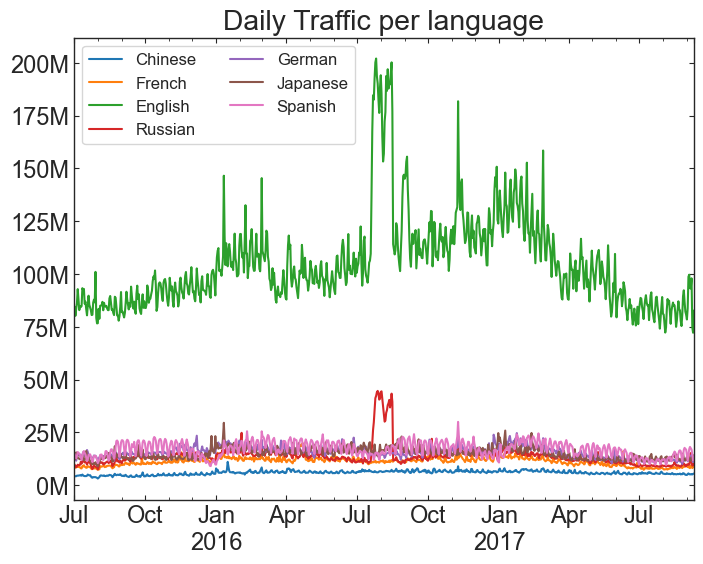

In [106]:
# tick format function 
# 'M' stands for million (1e6)
ticklabel_func = lambda value, tick_number: "{:.0f}M".format(value/1e6) 

ax = df_lang_traffic.plot()
ax.yaxis.set_major_formatter(plt.FuncFormatter(ticklabel_func))
ax.legend(loc='best', fontsize=12, ncol=2)
ax.set_title('Daily Traffic per language');

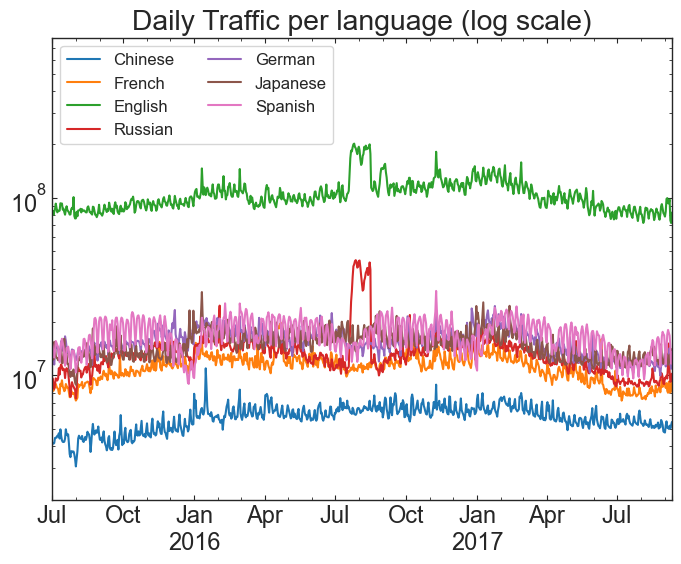

In [115]:
ax = df_lang_traffic.plot()
ax.legend(loc='upper left', fontsize=12, ncol=2)
ax.set_title('Daily Traffic per language (log scale)')
ax.set_yscale('log')
ax.set_ylim(2e6,8e8);

# Conclusion

The data consists of train and key, which contains daily traffic and map of page with id, respectively.
The train data contains 804 columns that consist of page and daily traffic for 803 days. The number of Wikipedia pages is 145k.

We found that there are two kinds of missing data, which are
- data is acutally missing
- the page is not created yet

For the former case, we interpolate the values to fill the missing ones, and for the latter, we simply fill it with zero value.